---
---

# IMPORTS

In [1]:
INTERACTIVE = False
FIGWIDTH    = 12


# CHOOSE INTERACTIVE ON/OFF
if INTERACTIVE:
    %matplotlib widget
else:
    %matplotlib inline
#----------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
from matplotlib.legend_handler import HandlerTuple
import pandas as pd
from scipy.interpolate import interp1d
import glob
import sys
sys.path.append('../')

import pynumdiff
import fillingpatterns as fp

# Make sure this import is after pandas
import Backend.ABPPandas

import Backend.Constants as cst
import Backend.NXCALS as nx


# Matplotlib config
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"


# Creating NXCALS variable containers
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]

buckets   = np.arange(3564)


# Locating data
DATA_PATH = '/eos/project/l/lhc-lumimod/LuminosityFollowUp/2022_test_v0.2.2/'
SAVEPATH  = '../Results_Lumi_V2/wires_on'

def importData(_fill,columns):
    # Importing fill data
    df = pd.read_parquet(DATA_PATH+f'HX:FILLN={FILL}',columns=columns)
    df = df.sort_index()
    df.index.name = 'unix'
    df.insert(0,'Timestamp',df.index)
    df.insert(1,'Time',1e-9*(df.index - df.index[0]))
    df['Timestamp'] = df['Timestamp'].apply(lambda t: pd.Timestamp(t).tz_localize('UTC'))
    return df

def wireROI(df):
    wire_start = df[df[wires['B1'][0]['I']]>10]['Timestamp'].min()
    wire_stop  = df[(df[wires['B1'][0]['I']]>295)&(df['Timestamp']>wire_start)]['Timestamp'].min()
    wire_start,wire_stop = wire_start-pd.Timedelta(minutes=3),wire_stop+pd.Timedelta(minutes=3)
    return wire_start,wire_stop


def getFillingPatt(df):

    filled_buckets = {}
    patterns       = {}
    bunch_I        = {}
    for beam in beams:
        
        filled_ts = np.min(df[df[beam['Intensity']]== np.max(df[beam['Intensity']])].index)

        sub = df.dropna(subset=[beam['bb_Intensity']])
        _ts = sub.index[sub.index.get_loc(filled_ts, method='nearest')]
        
        
        bunch_I[beam.name]        =df.loc[_ts,beam['bb_Intensity']]
        filled_buckets[beam.name] = np.arange(len(buckets))[bunch_I[beam.name]!=0]
        patterns[beam.name]       = (bunch_I[beam.name]!=0)


    # Figuring out filling patterns
    patt = fp.FillingPattern(patterns['B1'], patterns['B2'])
    patt.compute_beam_beam_schedule(n_lr_per_side=21)

    for bb_patt in [patt.b1,patt.b2]:
        train_num     = np.repeat(np.arange(len(bb_patt.train_lengths)),bb_patt.train_lengths)
        train_lengths = np.repeat(bb_patt.train_lengths,bb_patt.train_lengths)
        bb_patt.bb_schedule.insert(0,'Train',train_num)
        bb_patt.bb_schedule.insert(1,'Train Lengths',train_lengths)
        bb_patt.bb_schedule.insert(2,'Tag',None)


        targetTrain = bb_patt.bb_schedule['Train Lengths'].max()

        grouped = bb_patt.bb_schedule.groupby('Train')
        for train in list(grouped.groups.keys()):
            if grouped.get_group(train)['Train Lengths'].max() == targetTrain:
                _first  = grouped.get_group(train).index[0]
                _middle = grouped.get_group(train).index[targetTrain//2]

                bb_patt.bb_schedule.loc[_first,'Tag']  = 'first'
                bb_patt.bb_schedule.loc[_middle,'Tag'] = 'middle'

    return patt


2022-09-23 00:10:03,367 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



# Import single fill

In [2]:

FILL = 8120


# Importing some data for timescales
#-----------------------------------
var_needed  = ['HX:BMODE']
var_needed += [wire.I for wire in wires['B1']+wires['B2']]
var_needed += [beam['Intensity'] for beam in beams] + [beam['bb_Intensity'] for beam in beams]+ [beam['bb_Intensity_B'] for beam in beams]
var_needed += [beam['bb_Emittance_H'] for beam in beams] + [beam['bb_Emittance_V'] for beam in beams]

tune_vars = ['LhcStateTracker:LHCBEAM1:QH_TRIM:value',
             'LhcStateTracker:LHCBEAM1:QV_TRIM:value',
             'LhcStateTracker:LHCBEAM2:QH_TRIM:value',
             'LhcStateTracker:LHCBEAM2:QV_TRIM:value']

database             = importData(FILL,columns=var_needed+tune_vars)
wire_start,wire_stop = wireROI(database)
start_ts             = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
stop_ts              = wire_start+pd.Timedelta(hours=2)
patt                 = getFillingPatt(database) 
#-----------------------------------

# Loading effective cross section df
#-----------------------------------
xsection_df = {}
xsection_smooth_df = {}
for beam in beams:
    xsection_df[beam.name]        = pd.read_pickle(f"{SAVEPATH}/pickles/xsection_F{FILL}_{beam.name}.pkl")
    xsection_smooth_df[beam.name] = pd.read_pickle(f"{SAVEPATH}/pickles/xsection_smooth_F{FILL}_{beam.name}.pkl")
#-----------------------------------



Computing collision schedules...
Done Beam 1
Done Beam 2


# Test emittance

# Getting bb_parameters

In [3]:


def make_bb_parameters(df,_times):

    STABLE_start = df[df['HX:BMODE'] == 'STABLE']['Time'].iloc[0]

    # Computing avg (every 60 seconds)
    binWind = 60
    bins    = np.arange(_times[0]-binWind/2,_times[-1]+binWind/2+binWind/8,binWind)


    new_dict = {}
    for beam in beams:

        # INTENSITY
        observable = beam['Intensity']
        times,ref  = df.bin(observable,bins=bins)[['Time',observable]].T.to_numpy()
        STABLE_idx = np.argmin(np.abs(times-STABLE_start))

        observable = beam['bb_Intensity']
        total_A    = df.bin(observable,bins=bins)[observable]
        calib_A   = np.mean((ref/total_A.apply(lambda line:np.sum(line)))[STABLE_idx:STABLE_idx+int(10*(60/binWind))])

        new_dict[f'bb_Intensity_A_{beam.name}'] = total_A*calib_A

        observable = beam['bb_Intensity_B']
        total_B    = df.bin(observable,bins=bins)[observable]

        # B1 BCTFR-B needs rolling of 1 bucket (let's make it general):
        #-------------------------------------        
        rolling = buckets[(total_A.loc[STABLE_idx]!=0)&(buckets<3562)][-1]-buckets[(total_B.loc[STABLE_idx]!=0)&(buckets<3562)][-1]
        if rolling != 0 :
            total_B = total_B.apply(lambda line: np.roll(line,rolling))
            print(f'MISALIGNED {beam.name}, ROLLING BY {rolling}')
        #-------------------------------------
       
        calib_B   = np.mean((ref/total_B.apply(lambda line:np.sum(line)))[STABLE_idx:STABLE_idx+int(10*(60/binWind))])
        new_dict[f'bb_Intensity_B_{beam.name}']   = total_B*calib_B
        new_dict[f'bb_Intensity_avg_{beam.name}'] = (total_A*calib_A + total_B*calib_B)/2

        # Emittance:
        for plane in ['H','V']:
            observable = beam[f'bb_Emittance_{plane}']
            times_emitt,emitt = df.set_index('Time')[observable].dropna().to_2D()

            # Aligning times with interpolation
            #---------------------------------
            emitt = interp1d(times_emitt,emitt,axis=0,bounds_error=False,fill_value=np.nan)(times)
            emitt = pd.Series(list(emitt))

            # Test alignement?
            #-------------------------------------        
            #emitt_idx = emitt.dropna().index[np.argmin(np.abs(emitt.dropna().index - STABLE_idx))]
            rolling = buckets[(total_A.loc[STABLE_idx]!=0)&(buckets<3562)][-1]-buckets[(emitt.loc[STABLE_idx]!=0)&(buckets<3562)][-1]
            if rolling != 0 :
                emitt = emitt.apply(lambda line: np.roll(line,rolling))
                print(f'MISALIGNED EMITTANCE {beam.name}, ROLLING BY {rolling}')
            #-------------------------------------

            new_dict[f'bb_Emittance_{plane}_{beam.name}'] = emitt




    return pd.concat([  df.bin(beams[0]['Intensity'],bins=bins)[['unix','Timestamp','Time']],
                        pd.DataFrame(new_dict)],axis=1).set_index('unix')


assert(np.all(xsection_df['B1']['Time'] ==xsection_df['B2']['Time']))
bb_parameters = make_bb_parameters(database,_times=np.array(xsection_df['B1']['Time']))

MISALIGNED B1, ROLLING BY 1


# ULTIMATE PLOT

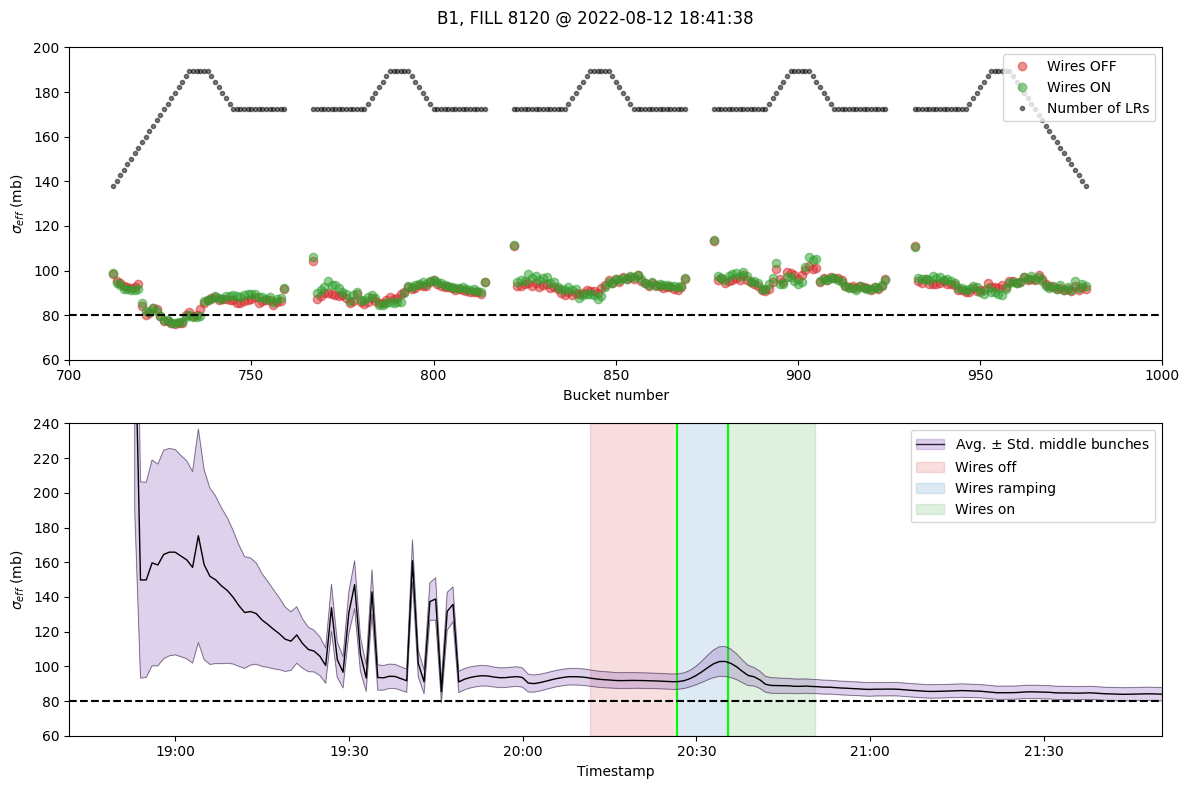

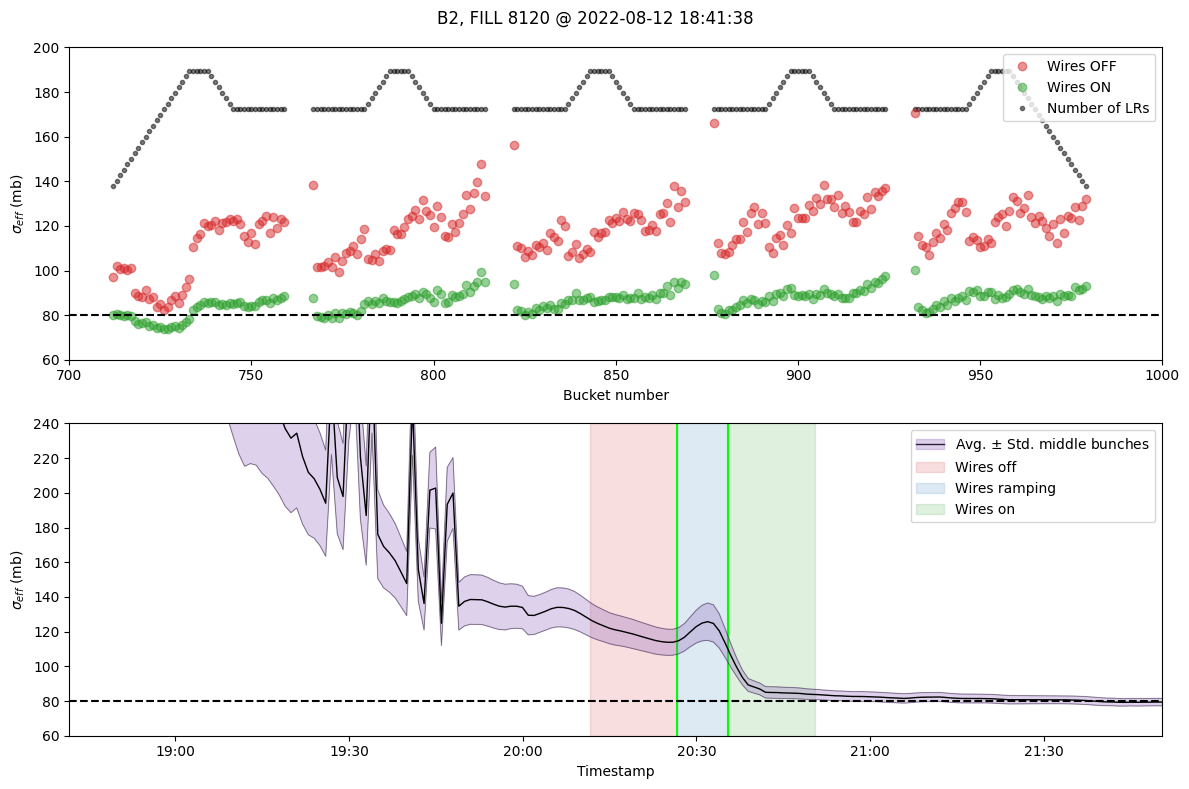

In [4]:


t0 = wire_start - pd.Timedelta(minutes=20)
t1 = wire_start
t2 = wire_stop
t3 = t2 + (t1-t0)


if FILL == 8102:
    t0 = wire_start - pd.Timedelta(minutes=20)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window = [t0-pd.Timedelta(hours=6.),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [820,1070]

if FILL == 8120:
    t0 = wire_start - pd.Timedelta(minutes=15)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=1.5),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]

if FILL == 8128:
    t0 = wire_start - pd.Timedelta(minutes=4)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=0.75),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]

if FILL == 8124:
    t0 = wire_start - pd.Timedelta(minutes=13)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=0.5),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]

if FILL == 8143:
    t0 = wire_start - pd.Timedelta(minutes=3)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=0.6),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]






for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):

    # COMPUTING BBLR
    #====================================================
    _N1    = bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{beam.name}'].loc[t0:t1].mean()
    _epsx1 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{beam.name}'].loc[t0:t1].mean()
    _epsy1 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_V_{beam.name}'].loc[t0:t1].mean()

    partner_beam = {'B1':beams[1],'B2':beams[0]}[beam.name]
    _N2    = bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{partner_beam.name}'].loc[t0:t1].mean()
    _epsx2 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{partner_beam.name}'].loc[t0:t1].mean()
    _epsy2 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_V_{partner_beam.name}'].loc[t0:t1].mean()


    Eff_LR       = np.nan*np.ones(len(buckets))
    BB_signature = np.nan*np.ones(len(buckets))
    study_bunches = bb_df.index[(bb_df.index>choosen_bunches[0])&(bb_df.index<choosen_bunches[1])]
    for bunch in study_bunches:
        partner_bunches = bb_df['BB partners in ATLAS/CMS'].loc[bunch]

        lumi_prop = (_epsx1[bunch]*_epsy1[bunch]*_epsx2[bunch]*_epsy2[bunch])**(1/4)/(_N1[bunch]*_N2[bunch])

        IP1_prop = 0.5*np.sum(_N2[list(partner_bunches.astype(int))]/_epsy2[list(partner_bunches.astype(int))])
        IP5_prop = 0.5*np.sum(_N2[list(partner_bunches.astype(int))]/_epsx2[list(partner_bunches.astype(int))])
        losses_prop = _N1[bunch]*(IP1_prop+IP5_prop)

        BB_signature[bunch] =  bb_df['# of LR in ATLAS/CMS'].loc[bunch]#losses_prop#(losses_prop) * lumi_prop
        Eff_LR[bunch]       = losses_prop/(_N1[bunch]*_N2[bunch])*np.sqrt(_epsx1[bunch]*_epsy1[bunch])

    BB_signature = BB_signature/np.max(BB_signature[~np.isnan(BB_signature)])
    #====================================================



    fig, axes = plt.subplots(figsize=(12,8),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})
    
    # TOP PLOT
    #===============================================================================
    plt.sca(axes[0])
    ROI_Before = xsection_df[beam.name].set_index('Timestamp').loc[ t0:t1]
    ROI_After  = xsection_df[beam.name].set_index('Timestamp').loc[ t2:t3]

    plt.plot(buckets,ROI_Before['sig_eff'].mean()/1e-3,'o',color='C3',alpha=0.5)
    plt.plot(buckets,ROI_After['sig_eff'].mean()/1e-3,'o',color='C2',alpha=0.5)


    # Manual legend
    plt.plot([np.nan],[np.nan],'o',color='C3',alpha=0.5,label = 'Wires OFF')
    plt.plot([np.nan],[np.nan],'o',color='C2',alpha=0.5,label = 'Wires ON')
    plt.plot([np.nan],[np.nan],'.',color='k',alpha=0.5,label = 'Number of LRs')
    plt.legend(loc='upper right')

    plt.axhline(80,ls='--',color='k')
    plt.ylim([60,200])
    plt.xlim(choosen_bunches)
    plt.xlabel('Bucket number')
    plt.ylabel(r'$\sigma_{eff}$ (mb)')

    # ADDING  LR PATTERN IN BACKGROUND
    #==================================
    plt.gca().set_frame_on(False)
    ax2 = plt.gca().twinx()
    ax2.set_zorder(-1)
    ax2.get_yaxis().set_visible(False)


    plt.plot(buckets,BB_signature,'.k',alpha=0.5,zorder=-10)
    plt.ylim([-0.25,1.1])
    
    #==================================
    #===============================================================================

    
    # BOTTOM PLOT
    #==============================================================================
    plt.sca(axes[1])
    middles =  bb_df.groupby('Tag').get_group('middle').index
    
    tagged  = list(middles)
    tagged += list(middles-1)
    tagged += list(middles+1)


    # Computing avg
    avg_ts              = xsection_smooth_df[beam.name]['Timestamp']
    avg_xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:np.mean(line[tagged]))

    # Computing std
    std_ts              = xsection_smooth_df[beam.name]['Timestamp']
    std_xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:np.std(line[tagged]))


    y0 = (avg_xsection_smooth)/1e-3
    y1 = (avg_xsection_smooth-std_xsection_smooth)/1e-3
    y2 = (avg_xsection_smooth+std_xsection_smooth)/1e-3
    x  = std_ts.loc[y1.dropna().index]

    color = 'C4'
    plt.fill_between(np.array(x),np.array(y1.dropna()),np.array(y2.dropna()),color=color,alpha=0.3)
    plt.plot(avg_ts,y0,color='k',ls = '-',lw=1,alpha=1)
    plt.plot(std_ts,y1,color='k',ls = '-',lw=0.5,alpha=0.5)
    plt.plot(std_ts,y2,color='k',ls = '-',lw=0.5,alpha=0.5)

    #





    plt.axhline(80,ls='--',color='k')
    plt.axvline(wire_start,color='lime',zorder=-5)
    plt.axvline(wire_stop,color='lime',zorder=-5)
    plt.fill_between([t0,t1], 0, 1, color='C3', alpha=0.15, transform=plt.gca().get_xaxis_transform(),label = 'Wires off',zorder=-10)
    plt.fill_between([t1,t2], 0, 1, color='C0', alpha=0.15, transform=plt.gca().get_xaxis_transform(),label = 'Wires ramping',zorder=-10)
    plt.fill_between([t2,t3], 0, 1, color='C2', alpha=0.15, transform=plt.gca().get_xaxis_transform(),label = 'Wires on',zorder=-10)
    # LEGEND
    #=====================================
    plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    line0, = plt.plot(avg_ts,np.nan*y0,color='k',ls = '-',lw=1,alpha=1)
    line1 =  plt.fill_between([np.nan],[np.nan],[np.nan],color=color,alpha=0.3)

    plt.legend([(line0,line1)]+handles, 
                [r'Avg. $\pm$ Std. middle bunches']+labels, handler_map = {tuple : HandlerTuple()})
    #====================================

    plt.ylim([60,240])
    plt.xlim(time_window)
    plt.ylabel(r'$\sigma_{eff}$ (mb)')
    plt.xlabel(r'Timestamp')



    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(time_window[0])[:19]}')
    plt.tight_layout()
    
    #plt.savefig(f'../Results_Lumi_V2/Uppsala/final_xsection_F{FILL}_{beam.name}.png',dpi=300)



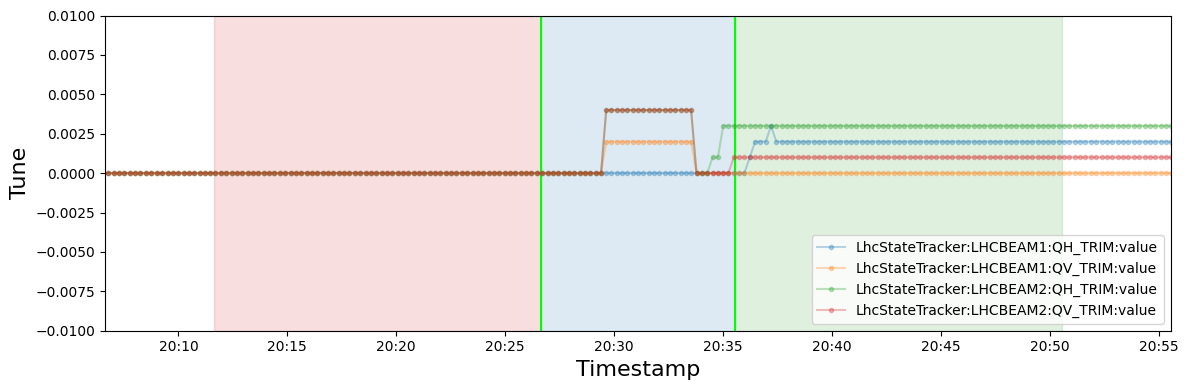

In [18]:
plt.figure(figsize=(12,4))
for ii in tune_vars:

    time = database.set_index('Timestamp')[ii].dropna().index[0:-1:500]
    data = database[ii].dropna().iloc[0:-1:500]
    ref = database.at_ts(t0 ,ii,method='nearest',return_ts=False)
    
    plt.plot(time,data-ref,'.-',alpha=0.3,label=ii)
    
plt.axvline(wire_start,color='lime',zorder=-5)
plt.axvline(wire_stop,color='lime',zorder=-5)
plt.fill_between([t0,t1], 0, 1, color='C3', alpha=0.15, transform=plt.gca().get_xaxis_transform(),zorder=-10)
plt.fill_between([t1,t2], 0, 1, color='C0', alpha=0.15, transform=plt.gca().get_xaxis_transform(),zorder=-10)
plt.fill_between([t2,t3], 0, 1, color='C2', alpha=0.15, transform=plt.gca().get_xaxis_transform(),zorder=-10)
plt.ylim([-1e-2,1e-2])
plt.xlim([t0-pd.Timedelta(minutes=5),t3+pd.Timedelta(minutes=5)])
plt.legend(fontsize=10,loc='lower right')
plt.ylabel('Tune',fontsize=16)
plt.xlabel('Timestamp',fontsize=16)
plt.tight_layout()
plt.savefig(f'../Results_Lumi_V2/Uppsala/tune_trim_F{FILL}.png',dpi=300)